# Reproduce the results for protein folding pathways

# 1. import packages

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
import seaborn as sns

In [2]:
from tqdm.notebook import tqdm

In [3]:
sys.path.append('../')
import gdnb

In [4]:
gdnb.set_default_style()

## 2. preprocess the distance data

In [5]:
# path_idx = 1 (hierarchical pathway); = 2 (collaborative pathway)
path_idx = 1
result_dir = f'results/pathway/path{path_idx}/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
path = gdnb.load_pathway(path_idx=path_idx, preprocess=False)

In [6]:
traj = np.loadtxt(path)

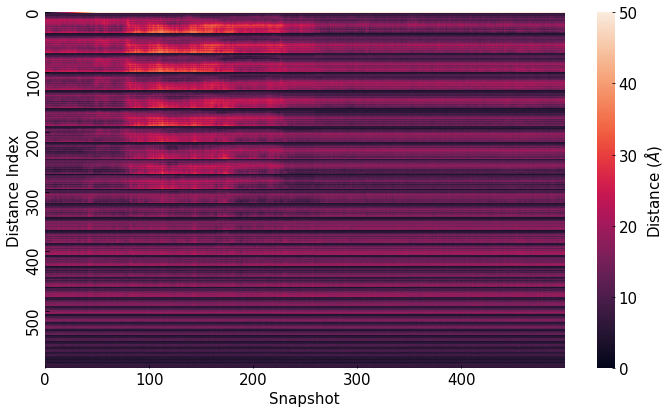

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(traj.T, vmin=0, vmax=50, xticklabels=100, yticklabels=100, cbar_kws={'label' : 'Distance ($\AA$)'})
ax.set_xlabel('Snapshot')
ax.set_ylabel('Distance Index')
plt.tight_layout()
# plt.savefig(f'{result_dir}dis_mat.png', dpi=200)

In [8]:
# normalize the data
traj = np.apply_along_axis(gdnb.normalize_by_mean, 0, traj[:, 1:])
disdat = traj.reshape(10, 50, -1).transpose((0, 2, 1))

In [9]:
# alternatively, you can set preprocess = True to do above procedures.
# disdat = gdnb.load_pathway(path_idx=1, preprocess=True)

## 3. applicate GDNB to the hierarchical folding trajectory

In [10]:
mydata = gdnb.GDNBData(disdat)

Read the input data ...
The input data shape is: 10 x 595 x 50
Number of windows: 10
Number of variables: 595
Number of samples: 50

The next step is fitting data by .fit()


In [11]:
mydata.fit(pv_cut=0.01, pcc_cut=0.05, fdr=True, pbar_mode=tqdm)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...



step 2: cluster selected variables ...



step 3: find the giant component (largest cluster) ...



fitting Done

--------------- Results Summary ---------------
number of variables in each largest cluster for each window:
[42, 157, 124, 140, 107, 77, 7, 8, 6, 5]

average PCC of each largest cluster for each window:
[0.7241541570158141, 0.8658392238099187, 0.7199958073419568, 0.7648239247017992, 0.8272048334269454, 0.8429311061247464, 0.9087484019857728, 0.9154732160972078, 0.9049507777195006, 0.9554426908993852]

average STD of each largest cluster for each window:
[0.07940660374197443, 0.19780363993578556, 0.11272550003656331, 0.16321853762218272, 0.14161658022307277, 0.0769887678909058, 0.04721404749045243, 0.0444900216000177, 0.052278270960009164, 0.04880182015135038]

composite index for each window:
[2.4151101321588477, 26.888785560798024, 10.064074038449547, 17.476681953960046, 12.5346134029695, 4.997009500364618, 0.30033983145760323, 0.32583538526721956, 0.2838555717785464, 0.23313671183097023]


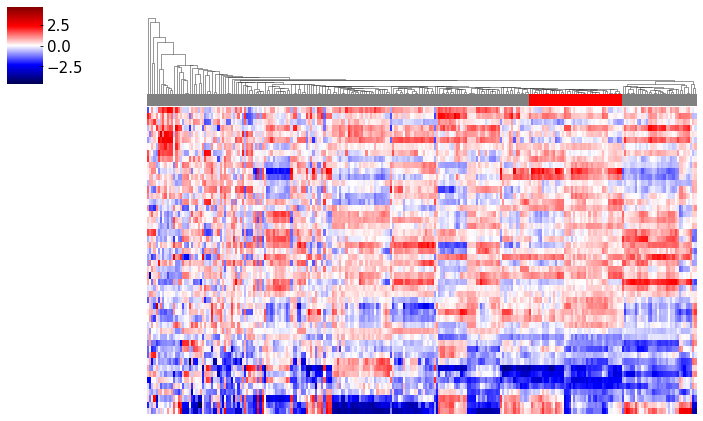

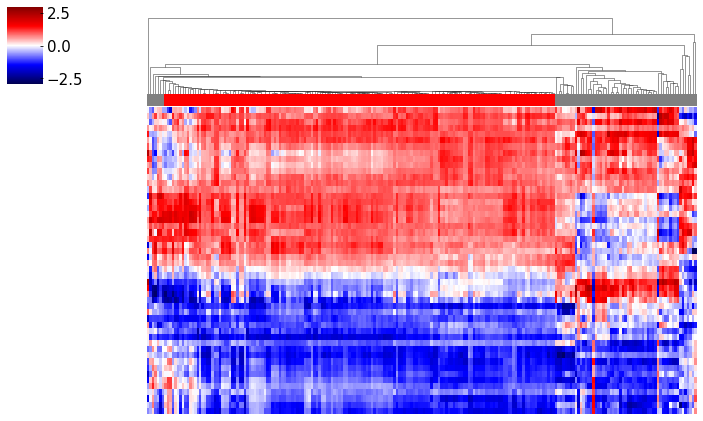

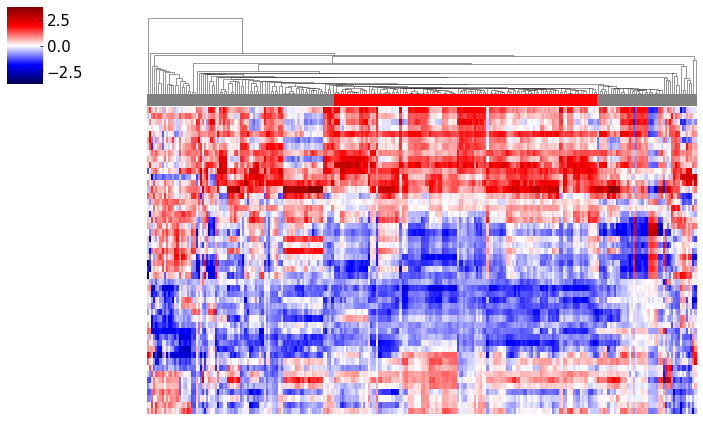

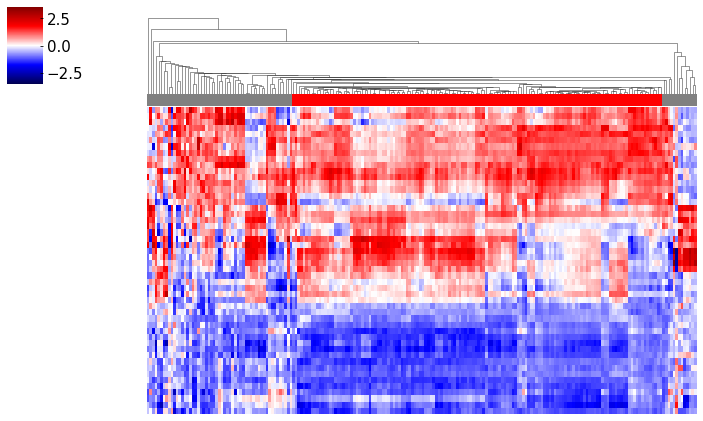

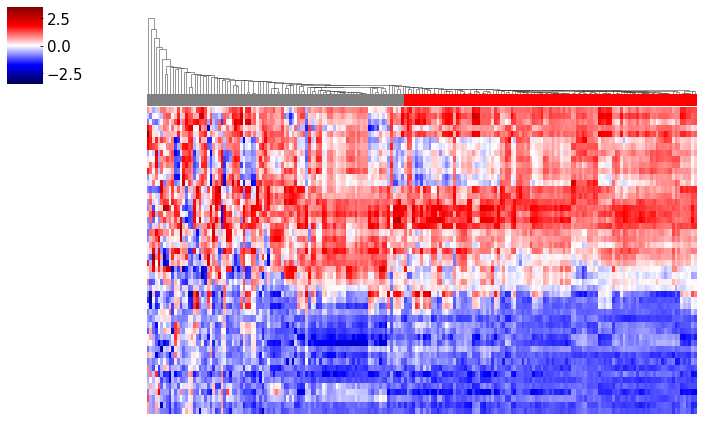

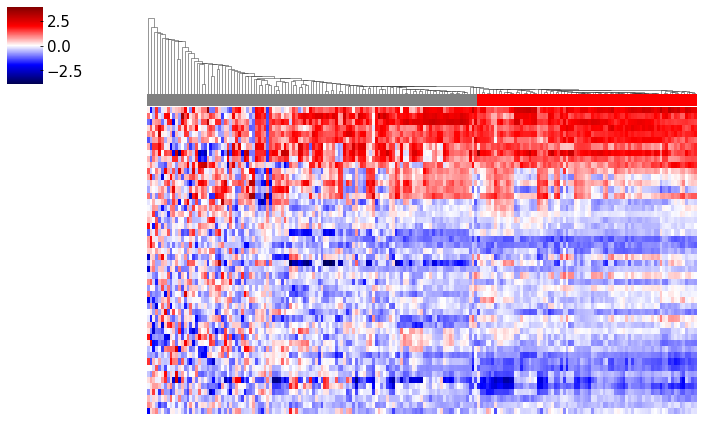

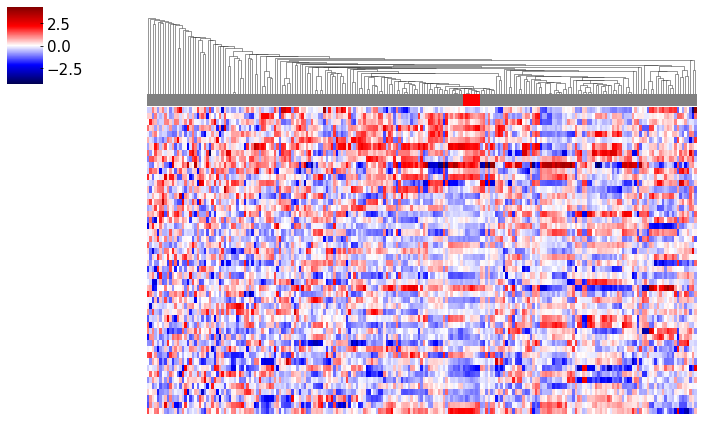

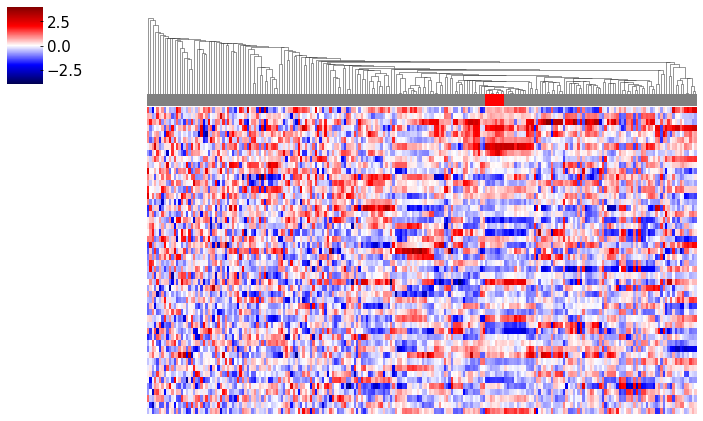

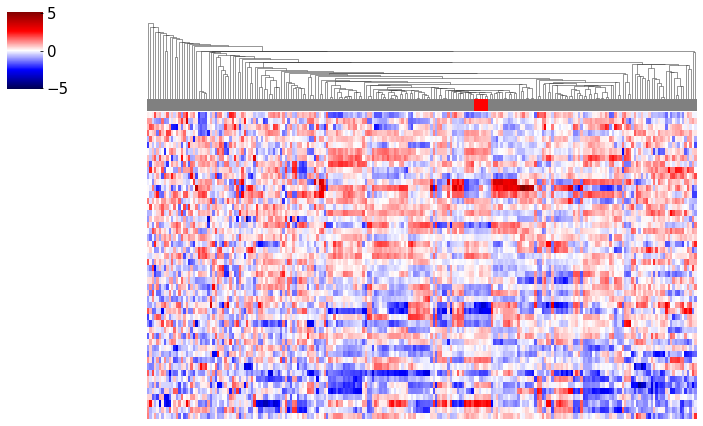

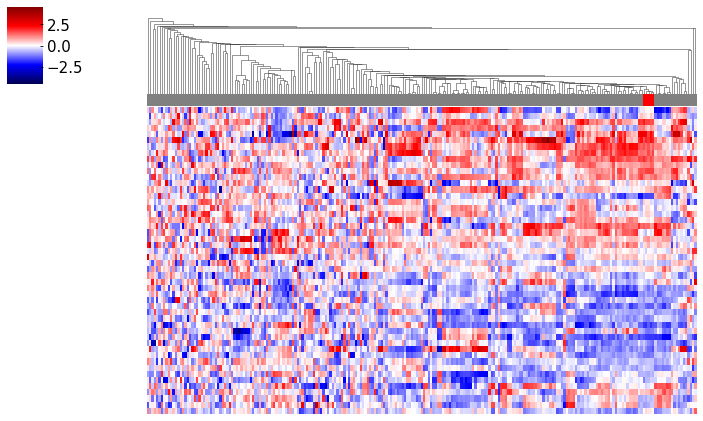

In [12]:
gs = mydata.plot_clusters(savefig=False, fig_path=result_dir)

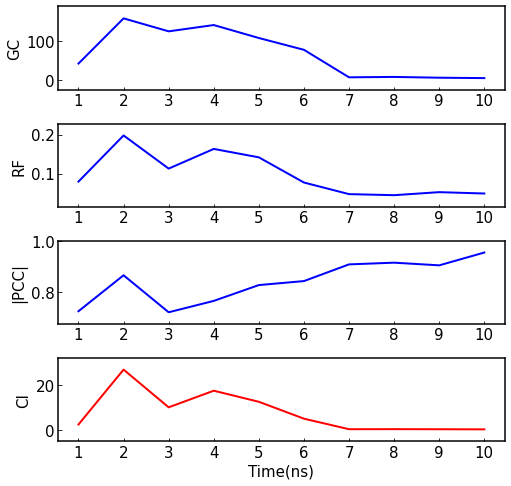

In [13]:
fig, ax = mydata.plot_index(xlabel='Time(ns)', xticklabels=range(1, 11))
# plt.savefig(f'{result_dir}four_index.svg', dpi=300, format='svg')

In [14]:
def plot_maps(data, nres=35, ncol=5, figsize=(15,6), square=False,
              clist=['wheat','gray','red'], interval=10, origin='upper'):
        fig,ax=plt.subplots(int(data.m / ncol), ncol, figsize=figsize)
        ax=ax.flatten()
        xy=[[i, j] for i in range(nres) for j in range(i+1, nres)]
        for t in range(data.m):
            plotmat=np.zeros((nres, nres))
            for i, (x, y) in enumerate(xy):
                if i in data.largest_cls[t]:
                    plotmat[x, y]=3
                elif i in data.sele_index[t]:
                    plotmat[x, y]=2
                else:
                    plotmat[x, y]=1
                    
            if square:
                plotmat = plotmat + plotmat.T
            plotmat[plotmat == 0] = np.nan
    
            cmap = mc.ListedColormap(clist)
            bounds = np.arange(0.5, 4)
            norm = mc.BoundaryNorm(bounds, cmap.N)
    
            ax[t].imshow(plotmat.T, norm=norm, cmap=cmap, origin=origin)
            sns.despine(ax=ax[t], left=True, bottom=True)
            ticks = np.arange(1, nres, interval)
            ax[t].set(xticks=ticks, yticks=ticks, 
                      title='{}ns'.format(t+1))
        fig.subplots_adjust(wspace=0.5, hspace=0.2)
        return fig, ax

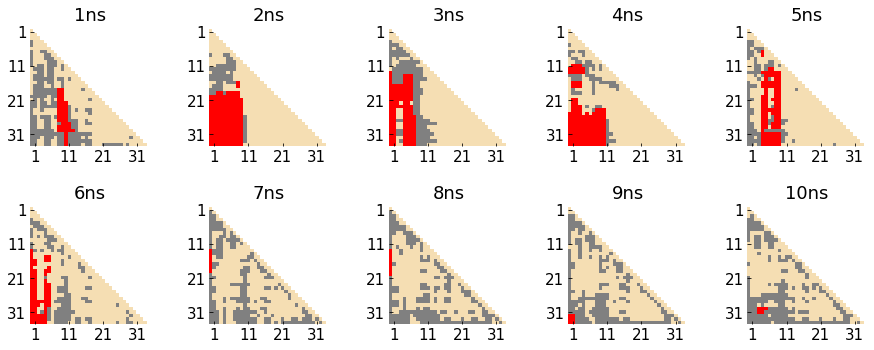

In [15]:
fig, ax = plot_maps(mydata)
# plt.savefig(f'{result_dir}map.svg', dpi=300, format='svg')

In [16]:
# save the giant component in each window
residue_table = np.array(
    [f'{i+1}_{j+1}' for i in range(35) for j in range(i+1, 35)])

for i in range(mydata.m):
    np.savetxt(result_dir + 'largest_cluster{}.txt'.format(i+1),
               residue_table[mydata.largest_cls[i]], 
               delimiter='\n', fmt='%s')

## 4. applicate GDNB to the collaborative folding trajectory

In [17]:
path_idx = 2
result_dir = f'results/pathway/path{path_idx}/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
# disdat = gdnb.load_pathway(path_idx=path_idx, preprocess=True)

In [18]:
path2 = gdnb.load_pathway(path_idx=path_idx, preprocess=False)
traj = np.loadtxt(path2)

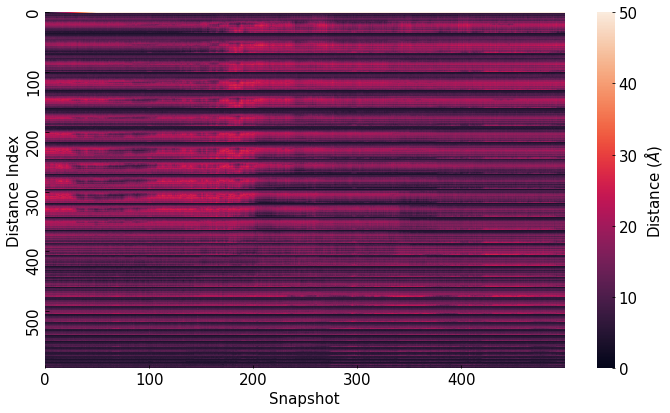

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(traj.T, vmin=0, vmax=50, xticklabels=100, yticklabels=100, cbar_kws={'label' : 'Distance ($\AA$)'})
ax.set_xlabel('Snapshot')
ax.set_ylabel('Distance Index')
plt.tight_layout()
# plt.savefig(f'{result_dir}dis_mat.png', dpi=200)

In [20]:
# normalize the data
traj = np.apply_along_axis(gdnb.normalize_by_mean, 0, traj[:, 1:])
disdat = traj.reshape(10, 50, -1).transpose((0, 2, 1))

In [21]:
mydata = gdnb.GDNBData(disdat)

Read the input data ...
The input data shape is: 10 x 595 x 50
Number of windows: 10
Number of variables: 595
Number of samples: 50

The next step is fitting data by .fit()


In [22]:
mydata.fit(pv_cut=0.01, pcc_cut=0.1, fdr=True, pbar_mode=tqdm)

fitting data using GDNB method ...
step 1: select the variables with high fluctuation ...



step 2: cluster selected variables ...



step 3: find the giant component (largest cluster) ...



fitting Done

--------------- Results Summary ---------------
number of variables in each largest cluster for each window:
[67, 94, 51, 179, 148, 75, 112, 47, 83, 44]

average PCC of each largest cluster for each window:
[0.7876516631106502, 0.6001797301499656, 0.8154024063716936, 0.49442407785944986, 0.6957341463530041, 0.6602357419835736, 0.5752780686169867, 0.8237729434623825, 0.8286073501545334, 0.8175580197073755]

average STD of each largest cluster for each window:
[0.1774525097873491, 0.12136080842807692, 0.10207251764108254, 0.1688923466394092, 0.10763003295033295, 0.10779587840372012, 0.07721328964262535, 0.1114008905052439, 0.1287887402380746, 0.11387922962287264]

composite index for each window:
[9.36464121863002, 6.846799941795619, 4.244739001956748, 14.947295251302812, 11.08251958630355, 5.337801882048843, 4.974940559363431, 4.3131448553642615, 8.857369632608155, 4.096526608076199]


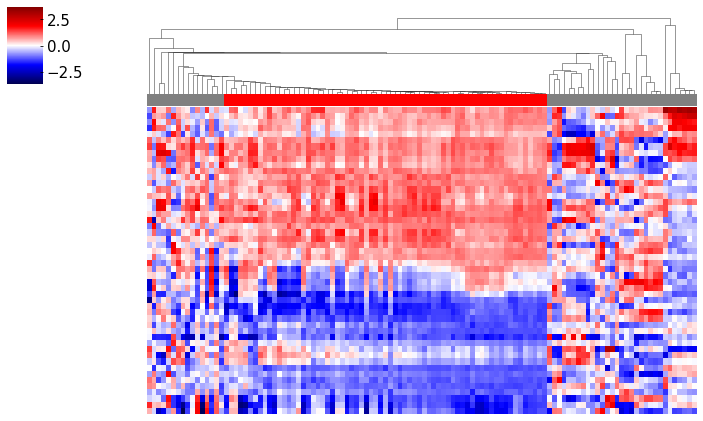

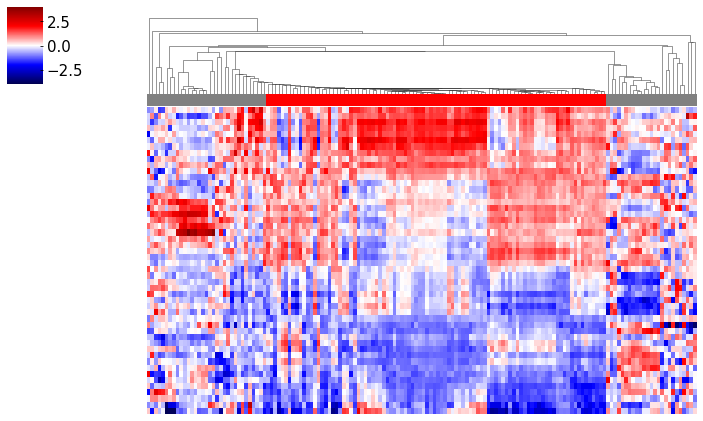

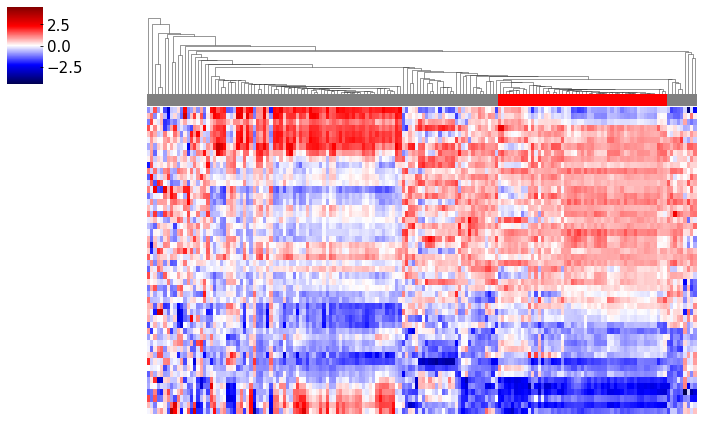

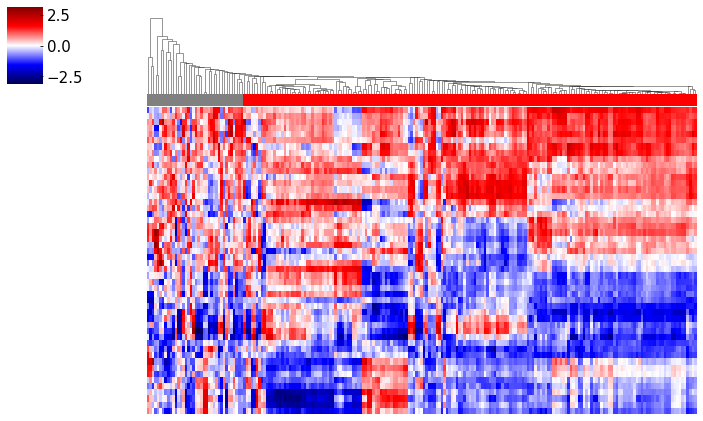

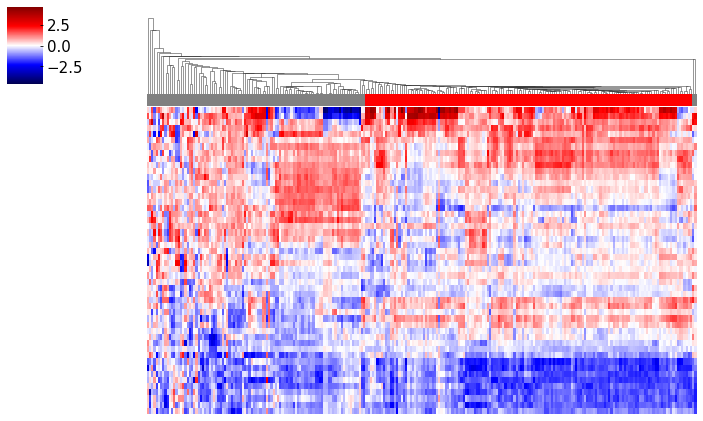

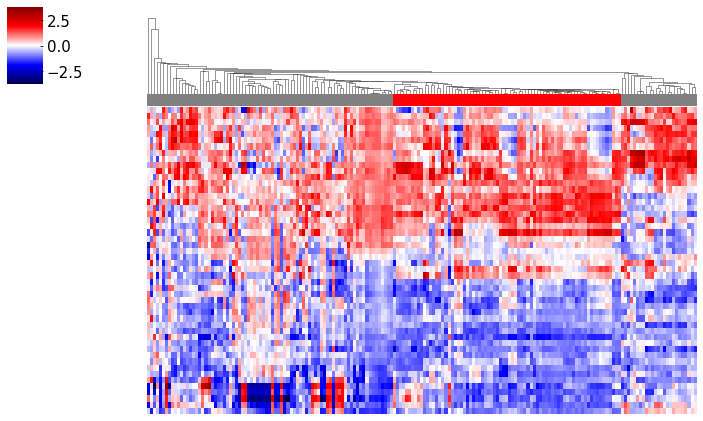

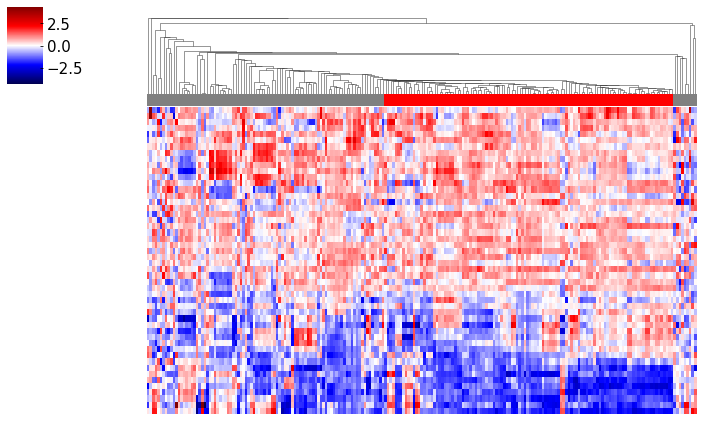

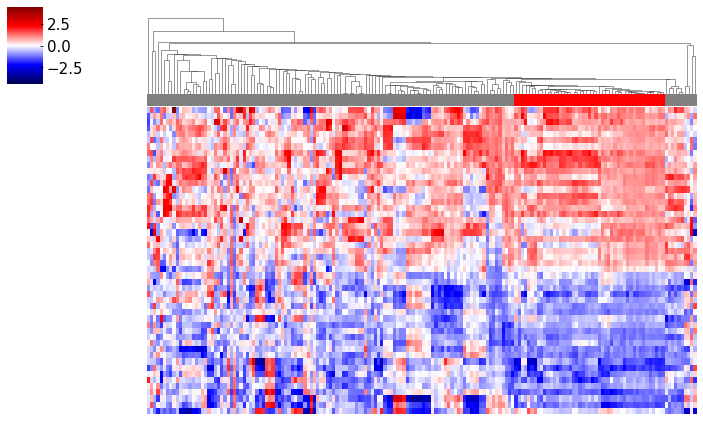

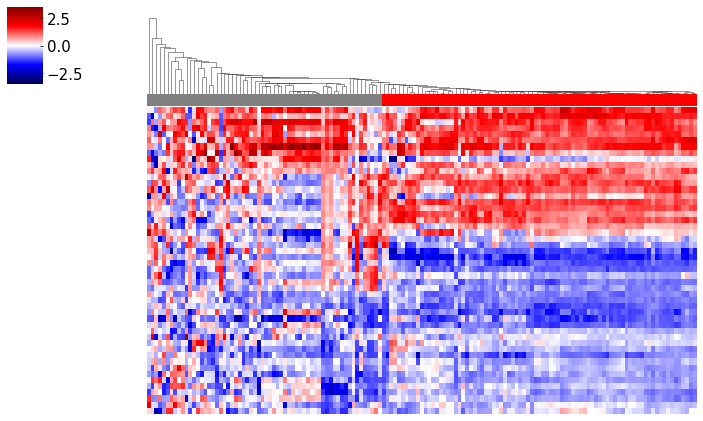

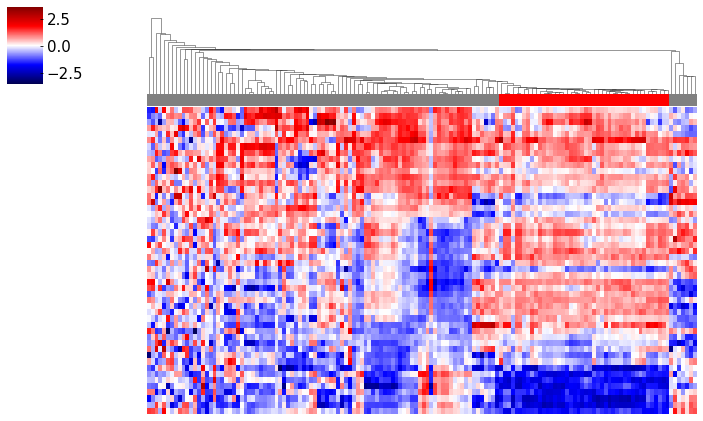

In [23]:
gs = mydata.plot_clusters(savefig=False, fig_path=result_dir)

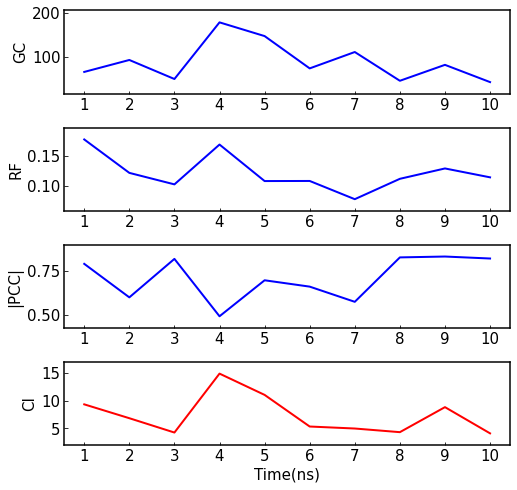

In [24]:
fig, ax = mydata.plot_index(xlabel='Time(ns)', xticklabels=range(1, 11))
# plt.savefig(f'{result_dir}four_index.svg', dpi=300, format='svg')

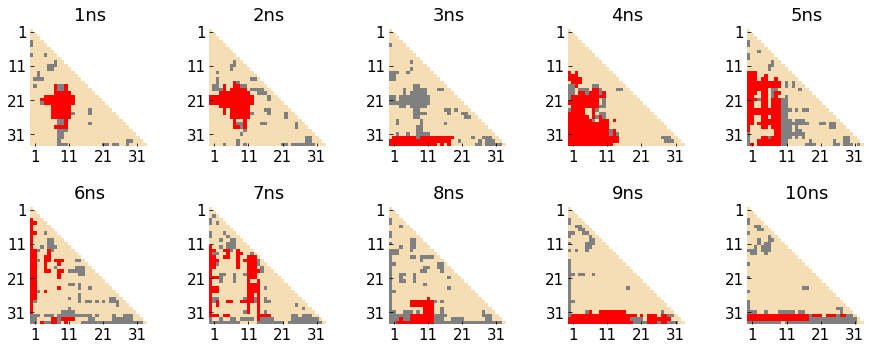

In [25]:
fig, ax = plot_maps(mydata)
# plt.savefig(f'{result_dir}map.svg', dpi=300, format='svg')

In [26]:
for i in range(mydata.m):
    np.savetxt(result_dir + 'largest_cluster{}.txt'.format(i+1),
               residue_table[mydata.largest_cls[i]], 
               delimiter='\n', fmt='%s')